# ConvoKit API functions for Q-A exploration

In [99]:
from convokit import Corpus, download
#from convokit.text_processing import TextToArcs
#from convokit.phrasing_motifs import PhrasingMotifs
from convokit import FightingWords

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import math

## Load corpus
Load all Q-A pairs for further exploration.

In [66]:
# Load all used corpora
tennis = Corpus('/home/karina/.convokit/downloads/tennis-corpus')
parliament = Corpus('/home/karina/.convokit/downloads/parliament-corpus')
reddit= Corpus('/home/karina/.convokit/downloads/reddit-coarse-discourse-corpus')

# Create a dataframe of all avoidance answers
all_ann = pd.read_csv('Data/Avoidance_annotated.csv')

In [67]:
# Load the 3 subcorpora

av_answers, av_fight_pairs, av_flight_pairs, non_av_pairs = [], [], [], []

for i in range(all_ann.shape[0]):
    if all_ann.iloc[i]['dataset'] == 'TI':
        utt = tennis.get_utterance(all_ann.iloc[i]['id_a'])
        utt.meta['strategy'] = all_ann.iloc[i]['avoid_type_avg']
        av_answers.append(utt)
        
        if utt.meta['strategy'] == 'Fight':
            av_fight_pairs.append((all_ann.iloc[i]['text_q'], all_ann.iloc[i]['text_a']))
        elif utt.meta['strategy'] == 'Flight':
            av_flight_pairs.append((all_ann.iloc[i]['text_q'], all_ann.iloc[i]['text_a']))
        else:
            non_av_pairs.append((all_ann.iloc[i]['text_q'], all_ann.iloc[i]['text_a']))
    if all_ann.iloc[i]['dataset'] == 'PQTC':
        utt = parliament.get_utterance(all_ann.iloc[i]['id_a'])
        utt.meta['strategy'] = all_ann.iloc[i]['avoid_type_avg']
        av_answers.append(utt)
        
        if utt.meta['strategy'] == 'Fight':
            av_fight_pairs.append((all_ann.iloc[i]['text_q'], all_ann.iloc[i]['text_a']))
        elif utt.meta['strategy'] == 'Flight':
            av_flight_pairs.append((all_ann.iloc[i]['text_q'], all_ann.iloc[i]['text_a']))
        else:
            non_av_pairs.append((all_ann.iloc[i]['text_q'], all_ann.iloc[i]['text_a']))
    elif all_ann.iloc[i]['dataset'] == 'CDC':
        utt = reddit.get_utterance(all_ann.iloc[i]['id_a'])
        utt.meta['strategy'] = all_ann.iloc[i]['avoid_type_avg']
        av_answers.append(utt)
        
        if utt.meta['strategy'] == 'Fight':
            av_fight_pairs.append((all_ann.iloc[i]['text_q'], all_ann.iloc[i]['text_a']))
        elif utt.meta['strategy'] == 'Flight':
            av_flight_pairs.append((all_ann.iloc[i]['text_q'], all_ann.iloc[i]['text_a']))
        else:
            non_av_pairs.append((all_ann.iloc[i]['text_q'], all_ann.iloc[i]['text_a']))
    else:
        pass
    
av_corpus = Corpus(utterances=av_answers)
print(av_corpus.random_utterance().meta)

{'is_question': False, 'is_answer': True, 'pair_idx': '1993-12-15.6.3', 'is_incumbent': False, 'is_minister': None, 'is_oppn': None, 'party': '<UNKNOWN>', 'strategy': 'Flight'}


## Data exploration / linguistic indicators
### (1) Frequency of ngrams for avoidance / non-avoidance and different strategies

#### 1.1 Avoidance vs. non-avoidance
Plot the log-odds ratio against frequency of the most frequent words for avoidance (class 1) and non-avoidance answers (class 2) respectively.
If an ngram has a z-score outside of \[-1.96, 1.96\] of belonging to one of two classes, it is very likely to be a feature of that class.

Initializing default CountVectorizer with ngram_range (1, 1)... Done.
class1_func returned 167 valid utterances. class2_func returned 232 valid utterances.
Vocab size is 293
Comparing language...
ngram zscores computed.


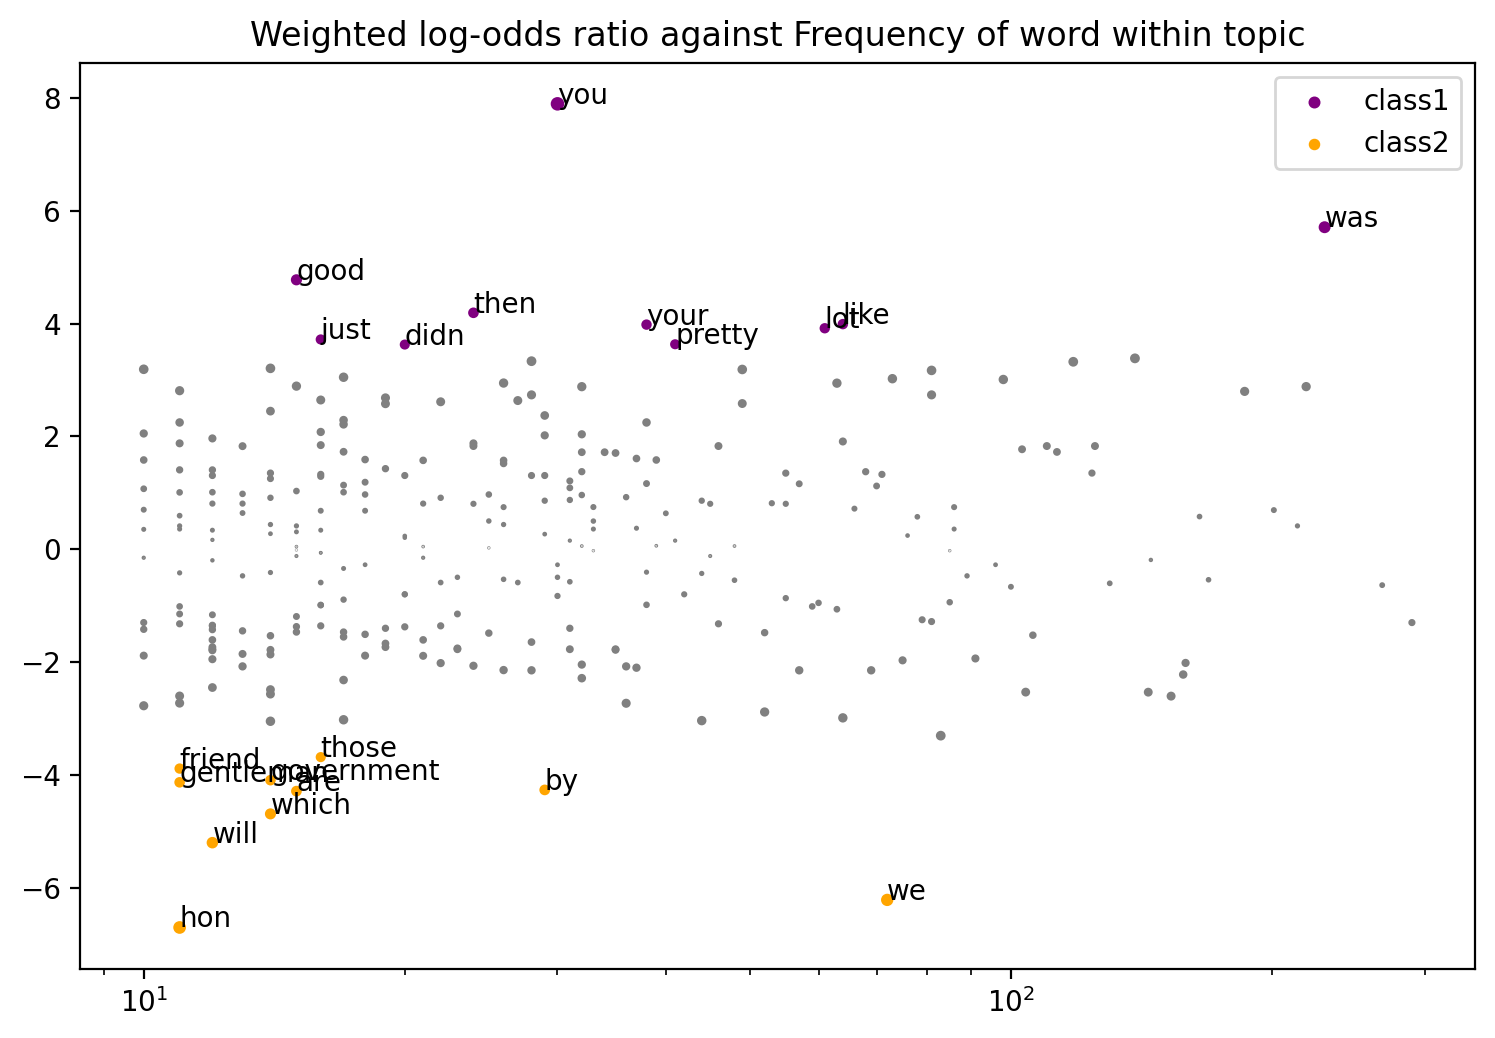

,z-score,class
ngram,,
hon,-6.707266,class2
we,-6.218318,class2
will,-5.203643,class2
which,-4.693055,class2
are,-4.289763,class2
...,...,...
like,3.991631,class1
then,4.192399,class1
good,4.777543,class1


In [68]:
# Extract fighting words from selected avoidance and non-avoidance
fw1 = FightingWords(ngram_range=(1,1))
fw1.fit(av_corpus, class1_func = lambda utt: utt.meta['strategy']!='Fight' and utt.meta['strategy']!='Flight' and utt.meta['strategy']!='Undetermined', 
        class2_func = lambda utt: utt.meta['strategy']=='Fight' or utt.meta['strategy']=='Flight')

# Plot
fw1.plot_fighting_words(max_label_size=15)
fw1.summarize(av_corpus)

In [69]:
# Most frequent ngrams for non-avoidance
print('10 most frequent words in non-avoidance answers: ', fw1.get_top_k_ngrams()[0])

# Most frequent ngrams for avoidance
print('10 most frequent words in avoidance answers: ', fw1.get_top_k_ngrams()[1])

10 most frequent words in non-avoidance answers:  ['you', 'was', 'good', 'then', 'like', 'your', 'lot', 'just', 'pretty', 'didn']
10 most frequent words in avoidance answers:  ['hon', 'we', 'will', 'which', 'are', 'by', 'gentleman', 'government', 'friend', 'those']


Initializing default CountVectorizer with ngram_range (2, 2)... Done.
class1_func returned 167 valid utterances. class2_func returned 232 valid utterances.
Vocab size is 123
Comparing language...
ngram zscores computed.


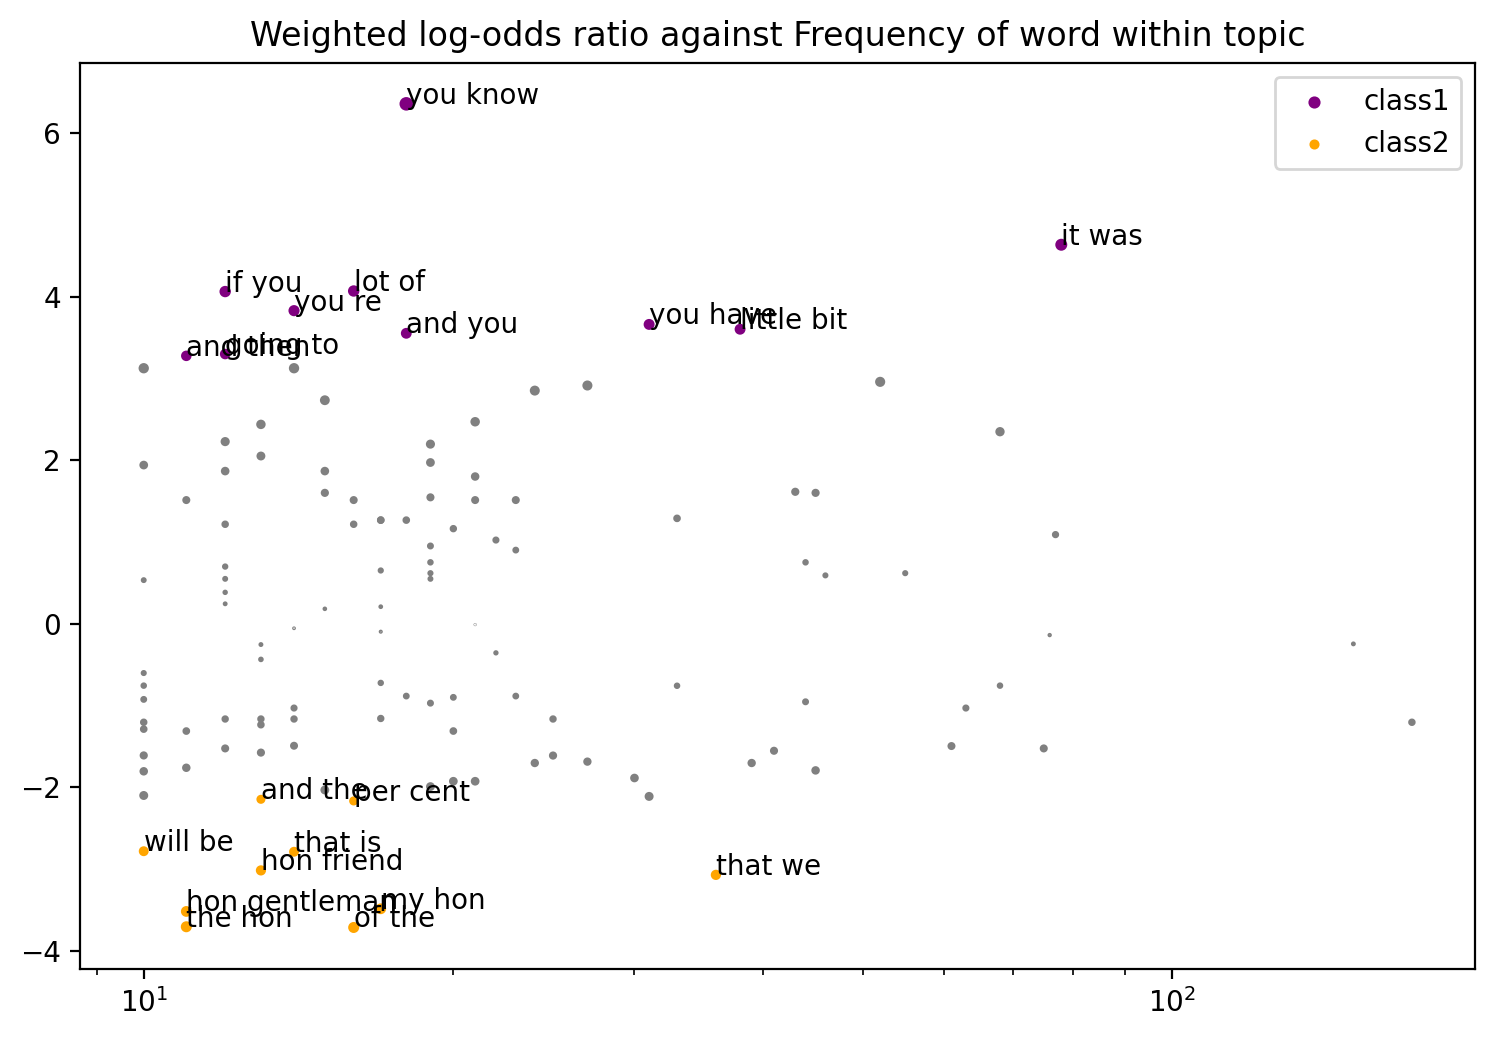

,z-score,class
ngram,,
of the,-3.715448,class2
the hon,-3.706698,class2
hon gentleman,-3.519345,class2
my hon,-3.486855,class2
that we,-3.071867,class2
...,...,...
you re,3.831300,class1
if you,4.064852,class1
lot of,4.071720,class1


In [70]:
# Bigrams scores
fw2 = FightingWords(ngram_range=(2,2))
fw2.fit(av_corpus, class1_func = lambda utt: utt.meta['strategy']!='Fight' and utt.meta['strategy']!='Flight' and utt.meta['strategy']!='Undetermined', 
        class2_func = lambda utt: utt.meta['strategy']=='Fight' or utt.meta['strategy']=='Flight')

# Plot
fw2.plot_fighting_words(max_label_size=15)
fw2.summarize(av_corpus)

In [71]:
# Most frequent bigrams for non-avoidance
print('10 most frequent bigrams in non-avoidance answers: ', fw2.get_top_k_ngrams()[0])

# Most frequent bigrams for avoidance
print('10 most frequent bigrams in avoidance answers: ', fw2.get_top_k_ngrams()[1])

10 most frequent bigrams in non-avoidance answers:  ['you know', 'it was', 'lot of', 'if you', 'you re', 'you have', 'little bit', 'and you', 'going to', 'and then']
10 most frequent bigrams in avoidance answers:  ['of the', 'the hon', 'hon gentleman', 'my hon', 'that we', 'hon friend', 'that is', 'will be', 'per cent', 'and the']


Initializing default CountVectorizer with ngram_range (3, 3)... Done.
class1_func returned 167 valid utterances. class2_func returned 232 valid utterances.
Vocab size is 7
Comparing language...
ngram zscores computed.


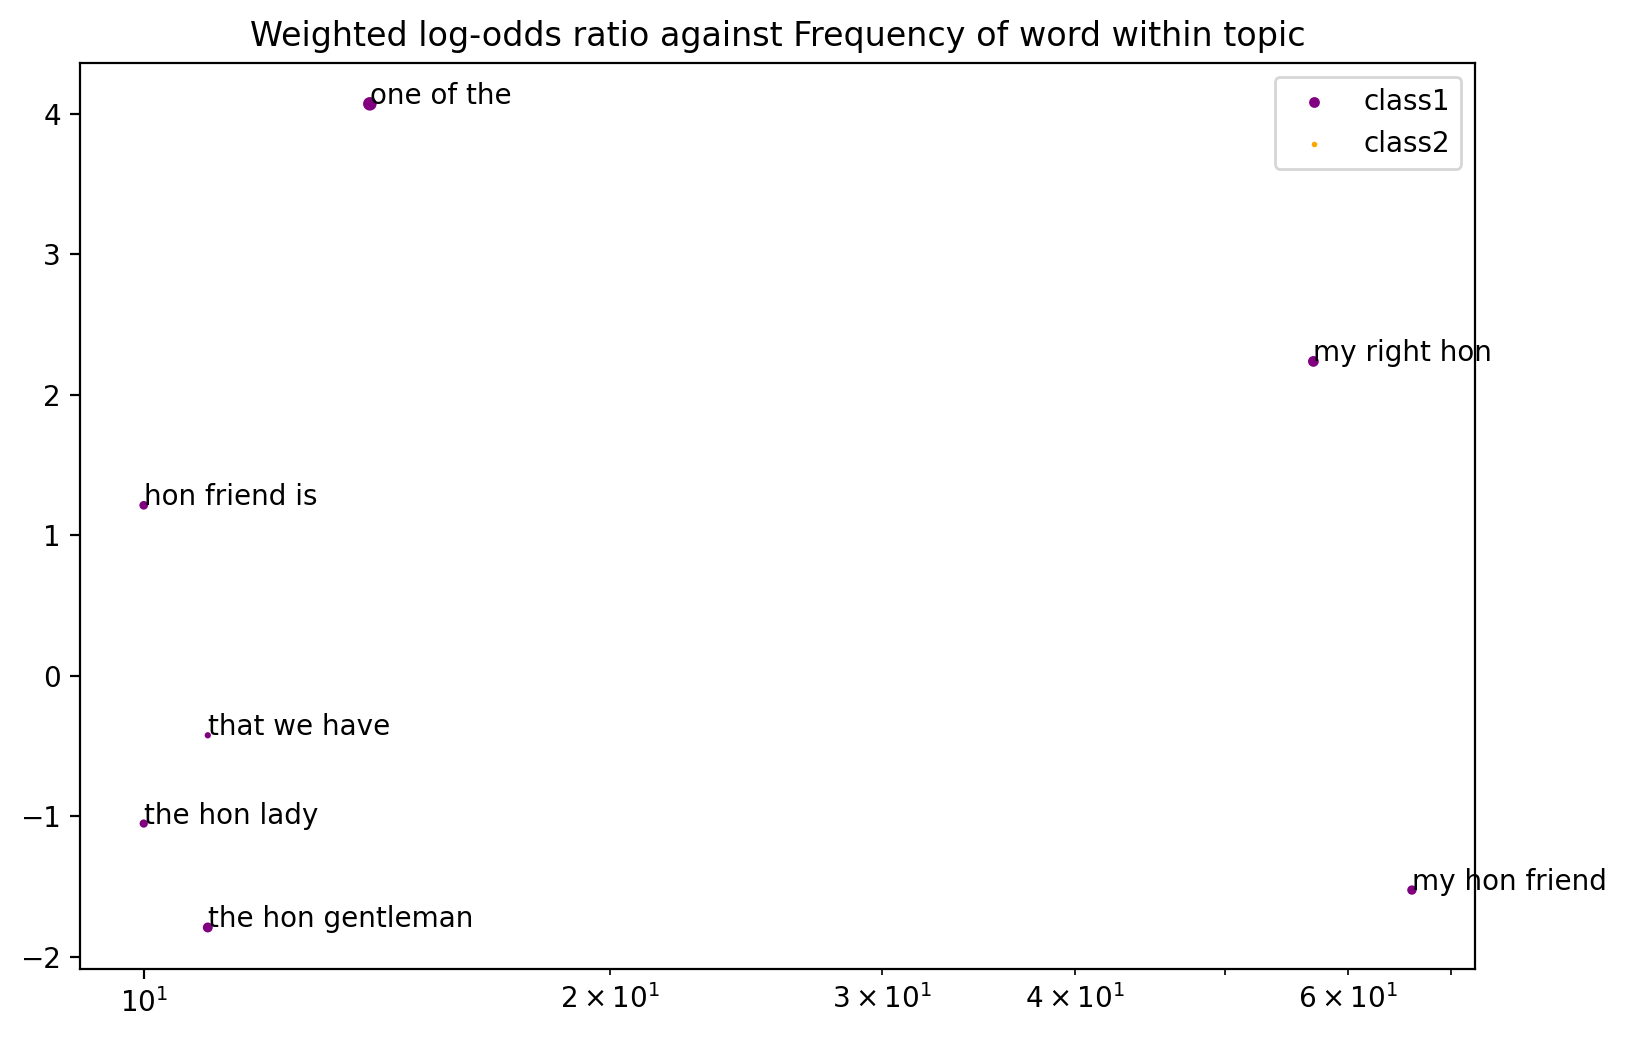

,z-score,class
ngram,,
the hon gentleman,-1.790448,class2
my hon friend,-1.524172,class2
the hon lady,-1.050894,class2
that we have,-0.422850,class2
hon friend is,1.213971,class1
my right hon,2.237883,class1
one of the,4.070862,class1


In [72]:
# Trigrams scores
fw3 = FightingWords(ngram_range=(3,3))
fw3.fit(av_corpus, class1_func = lambda utt: utt.meta['strategy']!='Fight' and utt.meta['strategy']!='Flight' and utt.meta['strategy']!='Undetermined', 
        class2_func = lambda utt: utt.meta['strategy']=='Fight' or utt.meta['strategy']=='Flight')

# Plot
fw3.plot_fighting_words(max_label_size=15)
fw3.summarize(av_corpus)

In [73]:
# Most frequent trigrams for non-avoidance
print('10 most frequent trigrams in non-avoidance answers: ', fw3.get_top_k_ngrams()[0])

# Most frequent trigrams for avoidance
print('10 most frequent trigrams in avoidance answers: ', fw3.get_top_k_ngrams()[1])

10 most frequent trigrams in non-avoidance answers:  ['one of the', 'my right hon', 'hon friend is', 'that we have', 'the hon lady', 'my hon friend', 'the hon gentleman']
10 most frequent trigrams in avoidance answers:  ['the hon gentleman', 'my hon friend', 'the hon lady', 'that we have', 'hon friend is', 'my right hon', 'one of the']


#### 1.2 'Fight' vs. 'Flight'
Plot the log-odds ratio against frequency of the most frequent words for avoidance answers using the 'Fight' (class 1) and 'Flight' (class 2) strategy respectively.

Initializing default CountVectorizer with ngram_range (1, 1)... Done.
class1_func returned 28 valid utterances. class2_func returned 204 valid utterances.
Vocab size is 193
Comparing language...
ngram zscores computed.


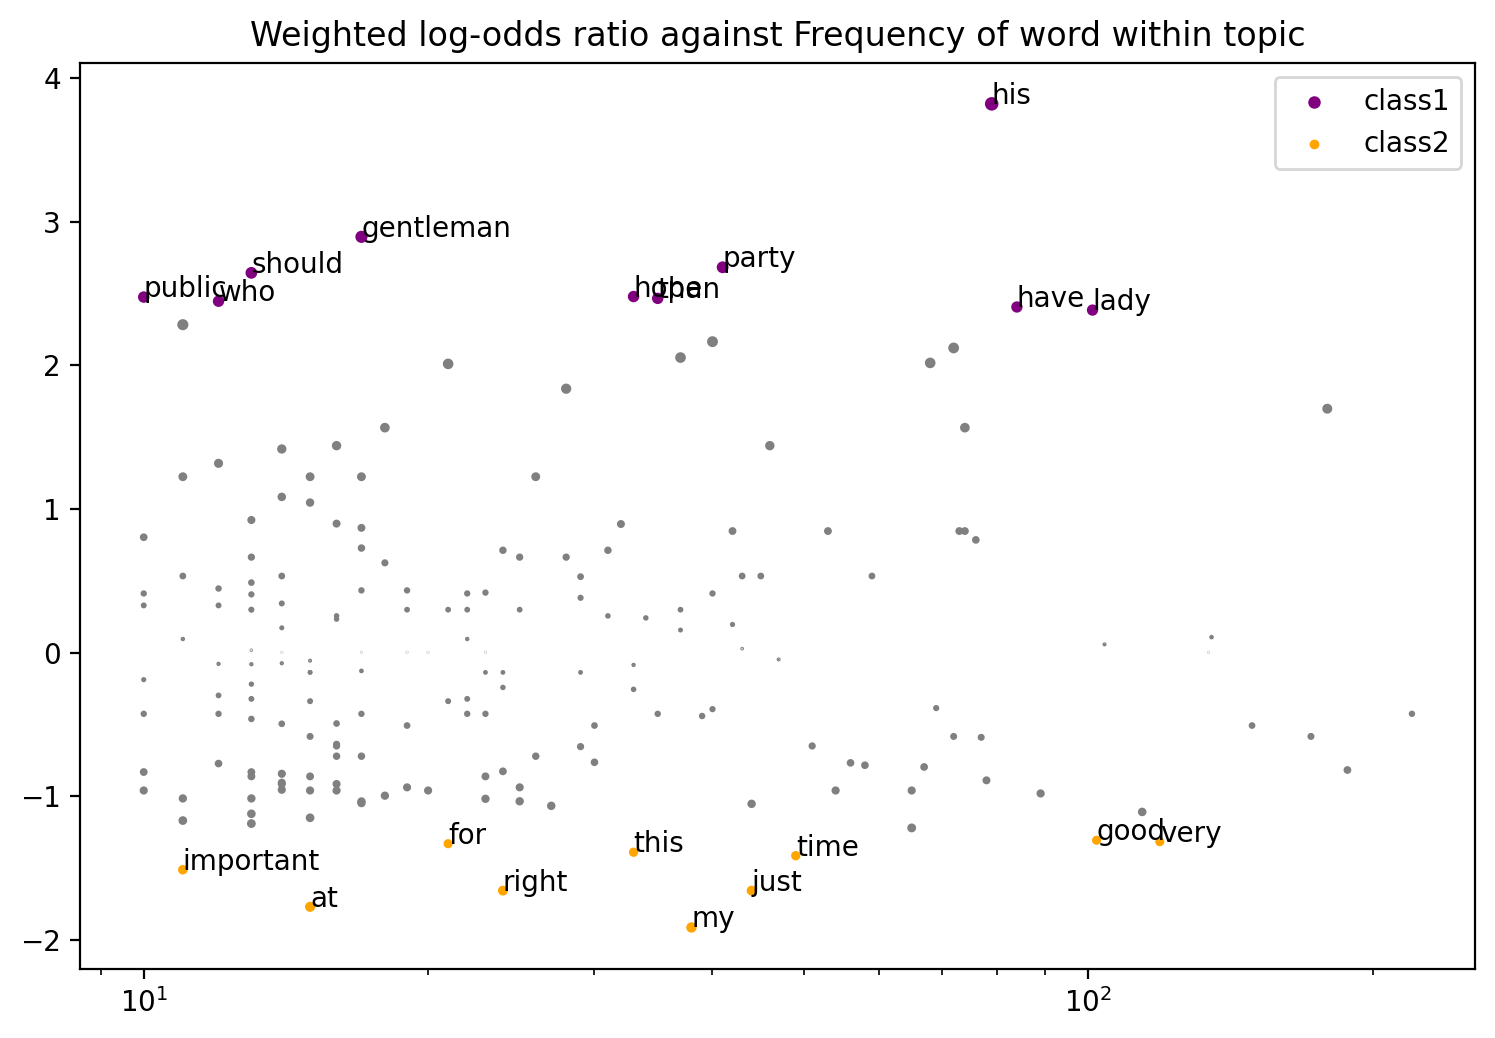

,z-score,class
ngram,,
my,-1.913622,class2
at,-1.769868,class2
just,-1.657004,class2
right,-1.657004,class2
important,-1.511552,class2
...,...,...
hope,2.479233,class1
should,2.644033,class1
party,2.682889,class1


In [74]:
# Extract fighting words from selected avoidance answers
fw1 = FightingWords(ngram_range=(1,1))
fw1.fit(av_corpus, class1_func = lambda utt: utt.meta['strategy']=='Fight', 
        class2_func = lambda utt: utt.meta['strategy']=='Flight')

# Plot
fw1.plot_fighting_words(max_label_size=15)
fw1.summarize(av_corpus)

In [75]:
# Most frequent words for 'Fight'
print('10 most frequent words in\'Fight\' answers: ', fw1.get_top_k_ngrams()[0])

# Most frequent words for 'Flight'
print('10 most frequent words in \'Flight\' answers: ', fw1.get_top_k_ngrams()[1])

10 most frequent words in'Fight' answers:  ['his', 'gentleman', 'party', 'should', 'hope', 'public', 'than', 'who', 'have', 'lady']
10 most frequent words in 'Flight' answers:  ['my', 'at', 'just', 'right', 'important', 'time', 'this', 'for', 'very', 'good']


Initializing default CountVectorizer with ngram_range (2, 2)... Done.
class1_func returned 28 valid utterances. class2_func returned 204 valid utterances.
Vocab size is 69
Comparing language...
ngram zscores computed.


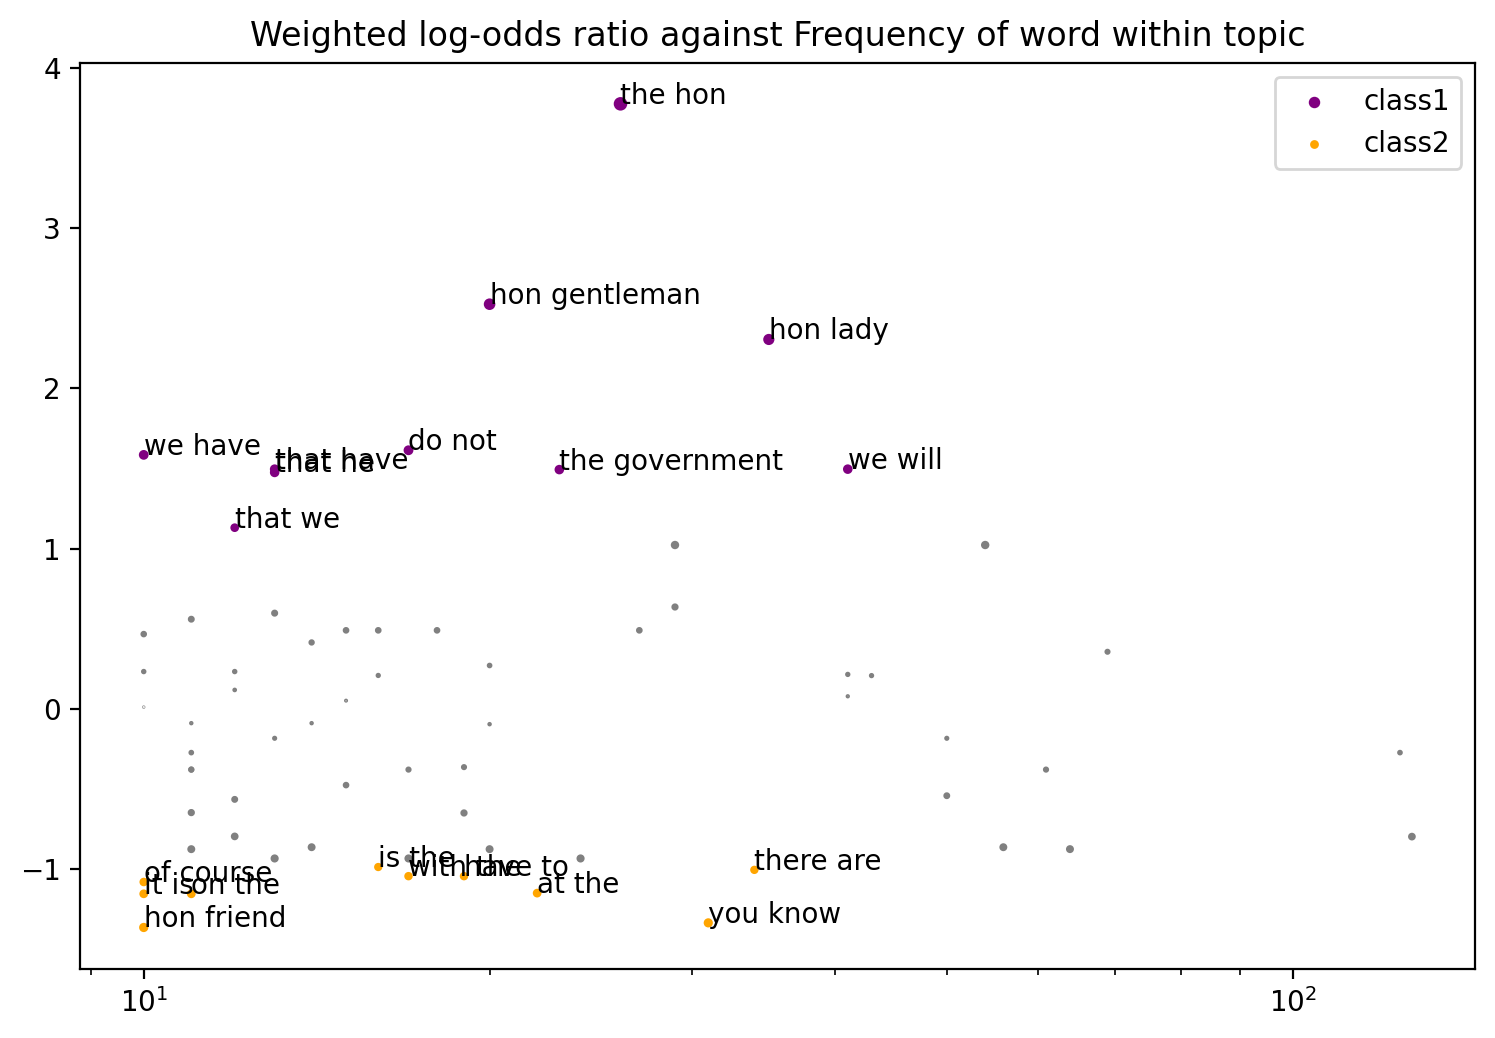

,z-score,class
ngram,,
hon friend,-1.364331,class2
you know,-1.335514,class2
on the,-1.154227,class2
it is,-1.154227,class2
at the,-1.149989,class2
...,...,...
we have,1.584930,class1
do not,1.613706,class1
hon lady,2.305116,class1


In [76]:
# Bigram scores
fw2 = FightingWords(ngram_range=(2,2))
fw2.fit(av_corpus, class1_func = lambda utt: utt.meta['strategy']=='Fight', 
        class2_func = lambda utt: utt.meta['strategy']=='Flight')

# Plot
fw2.plot_fighting_words(max_label_size=15)
fw2.summarize(av_corpus)

In [77]:
# Most frequent words for 'Fight'
print('10 most frequent bigrams in\'Fight\' answers: ', fw2.get_top_k_ngrams()[0])

# Most frequent words for 'Flight'
print('10 most frequent bigrams in \'Flight\' answers: ', fw2.get_top_k_ngrams()[1])

10 most frequent bigrams in'Fight' answers:  ['the hon', 'hon gentleman', 'hon lady', 'do not', 'we have', 'that have', 'we will', 'the government', 'that he', 'that we']
10 most frequent bigrams in 'Flight' answers:  ['hon friend', 'you know', 'on the', 'it is', 'at the', 'of course', 'with the', 'have to', 'there are', 'is the']


Initializing default CountVectorizer with ngram_range (3, 3)... Done.
class1_func returned 28 valid utterances. class2_func returned 204 valid utterances.
Vocab size is 3
Comparing language...
ngram zscores computed.


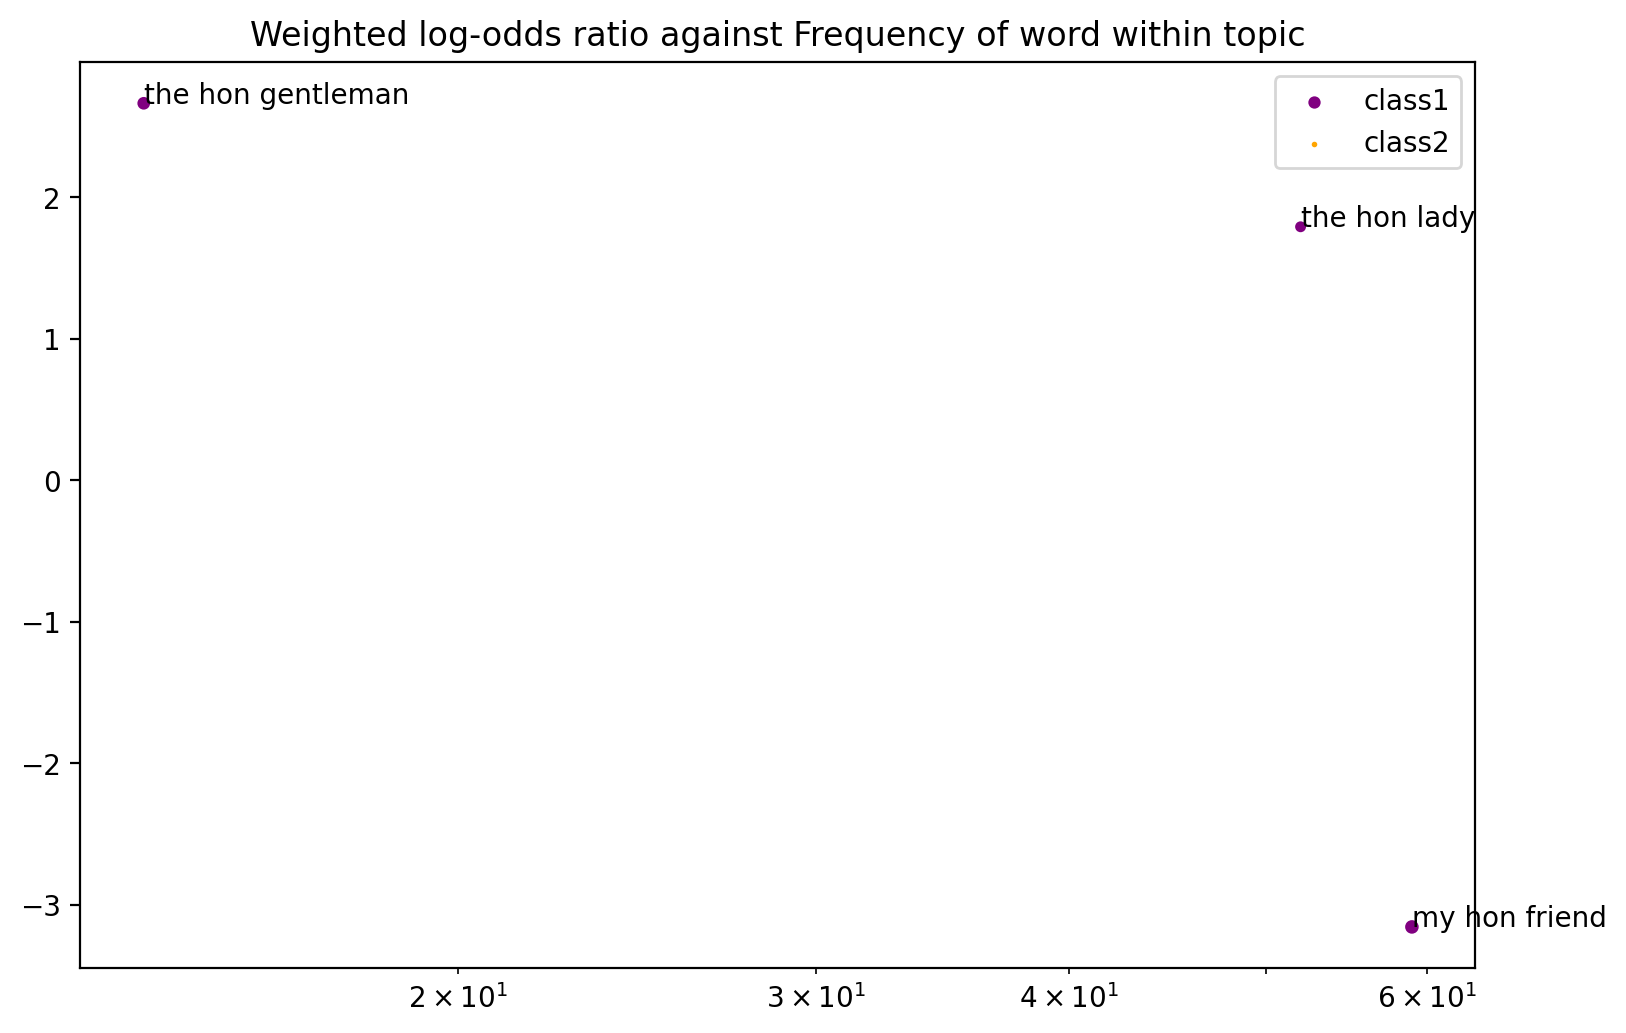

,z-score,class
ngram,,
my hon friend,-3.156479,class2
the hon lady,1.789797,class1
the hon gentleman,2.662261,class1


In [78]:
# Trigram scores
fw3 = FightingWords(ngram_range=(3,3))
fw3.fit(av_corpus, class1_func = lambda utt: utt.meta['strategy']=='Fight', 
        class2_func = lambda utt: utt.meta['strategy']=='Flight')

# Plot
fw3.plot_fighting_words(max_label_size=15)
fw3.summarize(av_corpus)

In [79]:
# Most frequent words for 'Fight'
print('10 most frequent bigrams in\'Fight\' answers: ', fw3.get_top_k_ngrams()[0])

# Most frequent words for 'Flight'
print('10 most frequent bigrams in \'Flight\' answers: ', fw3.get_top_k_ngrams()[1])

10 most frequent bigrams in'Fight' answers:  ['the hon gentleman', 'the hon lady', 'my hon friend']
10 most frequent bigrams in 'Flight' answers:  ['my hon friend', 'the hon lady', 'the hon gentleman']


### (2) Levenshtein distance between question and answer
Investigate whether there are significant differences between the Levenshtein distances of avoidance / non-avoidance QA pairs and 'Fight'/'Flight' pairs.

In [80]:
# https://www.python-course.eu/levenshtein_distance.php
def levenshtein(s, t):
    """ 
        iterative_levenshtein(s, t) -> ldist
        ldist is the Levenshtein distance between the strings 
        s and t.
        For all i and j, dist[i,j] will contain the Levenshtein 
        distance between the first i characters of s and the 
        first j characters of t
    """

    rows = len(s)+1
    cols = len(t)+1
    dist = [[0 for x in range(cols)] for x in range(rows)]

    # source prefixes can be transformed into empty strings 
    # by deletions:
    for i in range(1, rows):
        dist[i][0] = i

    # target prefixes can be created from an empty source string
    # by inserting the characters
    for i in range(1, cols):
        dist[0][i] = i
        
    for col in range(1, cols):
        for row in range(1, rows):
            if s[row-1] == t[col-1]:
                cost = 0
            else:
                cost = 1
            dist[row][col] = min(dist[row-1][col] + 1,      # deletion
                                 dist[row][col-1] + 1,      # insertion
                                 dist[row-1][col-1] + cost) # substitution    
 
    return dist[row][col]

In [158]:
def levenshtein1(q, a, threshold):
    """ Compute Levenshtein distance for a QA pair"""
    
    # Only compute Levenshtein distance if question and answer don't differ too much in length
    if max(len(q), len(a))-min(len(q), len(a)) > threshold:
        return
    else:
        return levenshtein(q, a)

In [159]:
# Average Levenshtein distance for non-avoidance Q-A pairs
non_av_dist = 0.0
non_av_distances = []
i = 0
for q, a in non_av_pairs:
    dist = levenshtein1(q, a, 20)
    if dist != None:
        non_av_dist += dist
        non_av_distances.append(dist)
        i += 1
    
# Average Levenshtein distance for avoidance Q-A pairs
av_fight_dist, av_flight_dist = 0.0, 0.0
flight_distances, fight_distances = [], []
j, k = 0, 0
for q, a in av_flight_pairs:
    dist = levenshtein1(q, a, 20)
    if dist != None:
        av_flight_dist += dist
        flight_distances.append(dist)
        j += 1
        
for q, a in av_fight_pairs:
    dist = levenshtein1(q, a, 50)
    if dist != None:
        av_fight_dist += dist
        fight_distances.append(dist)
        k += 1

In [160]:
# Average Levenshtein distance for non-avoidance
print('Average Levenshtein distance for non-avoidance Q-A pairs: ', non_av_dist/i)

# Average Levenshtein distance for avoidance Q-A pairs
print('Average Levenshtein distance for avoidance Q-A pairs: ', (av_flight_dist+av_fight_dist)/j+k)

Average Levenshtein distance for non-avoidance Q-A pairs:  102.3076923076923
Average Levenshtein distance for avoidance Q-A pairs:  280.2083333333333


Average Levenshtein distance for 'Flight' Q-A pairs:  212.29166666666666


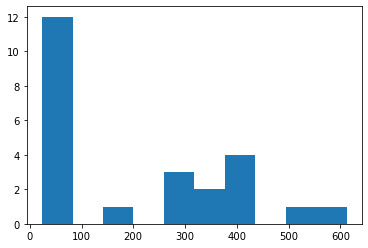

Average Levenshtein distance for 'Fight' Q-A pairs:  302.0


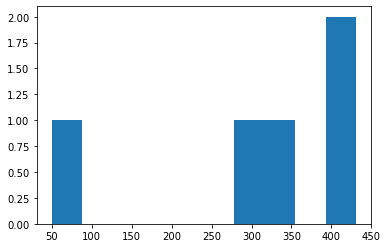

In [161]:
# Average Levenshtein distance for 'Flight' avoidance
print('Average Levenshtein distance for \'Flight\' Q-A pairs: ', av_flight_dist/j)
fig = plt.hist(flight_distances)
plt.show()

# Average Levenshtein distance for 'Fight' avoidance
print('Average Levenshtein distance for \'Fight\' Q-A pairs: ', av_fight_dist/k)
fig = plt.hist(fight_distances)
plt.show()

In [162]:
# Percentiles for non-avoidance
print('10% percentile for non-avoidance Q-A pairs: ', np.percentile(non_av_distances, 10))
print('90% percentile for non-avoidance Q-A pairs: ', np.percentile(non_av_distances, 90))

10% percentile for non-avoidance Q-A pairs:  22.400000000000002
90% percentile for non-avoidance Q-A pairs:  205.39999999999998


In [163]:
# Average Levenshtein distance for avoidance Q-A pairs
av_distances = flight_distances
for d in fight_distances:
    av_distances.append(d)
    
print('10% percentile for avoidance Q-A pairs: ', np.percentile(av_distances, 10))
print('90% percentile for avoidance Q-A pairs: ', np.percentile(av_distances, 90))

# Flight
print('10% percentile for flight avoidance Q-A pairs: ', np.percentile(flight_distances, 10))
print('90% percentile for flight avoidance Q-A pairs: ', np.percentile(flight_distances, 90))

# Fight
print('10% percentile for fight avoidance Q-A pairs: ', np.percentile(fight_distances, 10))
print('90% percentile for fight avoidance Q-A pairs: ', np.percentile(fight_distances, 90))

10% percentile for avoidance Q-A pairs:  38.400000000000006
90% percentile for avoidance Q-A pairs:  428.6
10% percentile for flight avoidance Q-A pairs:  38.400000000000006
90% percentile for flight avoidance Q-A pairs:  428.6
10% percentile for fight avoidance Q-A pairs:  153.2
90% percentile for fight avoidance Q-A pairs:  417.4
